In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from edge_detection import edge_detection
import cv2

import evolib

0.9579287762582379 -0.3741373114400731


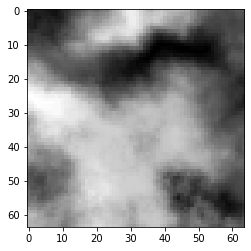

In [4]:
width = 64
height = 64

tn = evolib.TerrianNoise(
    seed=12342234,
    frequency=0.9,
    power=2.0,
    roughness=20,
    chunk_size=64,
    world_size=256,
)
#image = np.zeros((width, height))

n1 = tn.noise_chunk(0, 0)
image1 = np.array(n1)

# n2 = tn.noise_chunk(width, 0, width)
# image2 = np.array(n2)

# image = np.concatenate((image1, image2), axis=0)

max = np.max(image1)
min = np.min(image1)

print(max, min)

# for i in range(width):
#     for j in range(height):
#         x = i / width
#         y = j / height
#         image[i][j] = tn.noise(x, y)

plt.imshow(image1, cmap='gray')
plt.show()

In [ ]:
grid = np.zeros((300, 300))
plants = []

neighbor_matrix = np.array([
    [1, 0], # right
    [1, 1], # up-right
    [0, 1], # up
    [-1, 1], # up-left
    [-1, 0], # left
    [-1, -1], # down-left
    [0, -1], # down
    [1, -1] # down-right
])

def add_plant(pos):
    plants.append(pos)
    grid[pos[0], pos[1]] = 1

def can_reproduce(pos):
    """
    If there is an empty space next to the plant, it can reproduce.
    """
    for n in neighbor_matrix:
        neighbor = pos + n
        if grid[neighbor[0], neighbor[1]] == 0:
            return True

    return False

def get_direction(angle):
    t = np.tan(angle)
    if between(angle, 0, 15) or between(angle, 345, 360):
        t = np.array([1, 0]) # right
    elif between(angle, 15, 75):
        t = np.array([1, 1]) # up-right
    elif between(angle, 75, 105):
        t = np.array([0, 1]) # up
    elif between(angle, 105, 165):
        t = np.array([-1, 1]) # up-left
    elif between(angle, 165, 195):
        t = np.array([-1, 0]) # left
    elif between(angle, 195, 255):
        t = np.array([-1, -1]) # down-left
    elif between(angle, 255, 285):
        t = np.array([0, -1]) # down
    elif between(angle, 285, 345):
        t = np.array([1, -1]) # down-right
    return t

def get_circle_selection(pos, radius):
    selections = []
    range_x = range(pos[0] - radius, pos[0] + radius)
    range_y = range(pos[1] - radius, pos[1] + radius)
    for x in range_x:
        for y in range_y:
            if grid[x, y] == 1:
                selections.append(np.array([x, y]))
    return selections

def get_direct_neighbors(pos):
    neighbors = []
    for n in neighbor_matrix:
        neighbor = pos + n
        if grid[neighbor[0], neighbor[1]] == 1:
            neighbors.append(neighbor)
    return neighbors

def between(a, b, c):
    return a >= b and a <= c

def get_neighbor_vector(plant):
    neighbors = get_circle_selection(plant, radius=5)
    if len(neighbors) > 0:
        vectors = []
        for npos in neighbors:
            if np.array_equal(npos, plant):
                continue
            vec = plant - npos
            vectors.append(vec)
        if len(vectors) > 0:
            nvec = np.array(-sum(vectors), dtype=np.float64)
            nvec /= np.linalg.norm(nvec)
            return nvec

def moving_avg(x, n):
    #np.convolve(x, np.ones(n), 'valid') / n
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[n:] - cumsum[:-n]) / float(n)

def get_wind_vector(vecs, index):
    n = 50
    s = index-n
    if s < 0:
        s = 0
    svecs = vecs[s:index]
    if len(svecs) == 0:
        return np.array([0, 0])
    return sum(svecs) / len(svecs) 

grid

In [ ]:
first_plant = np.array([150, 150])
add_plant(first_plant)

# direction of the wind
wvecs = []
for i in range(1000):
    wvecs.append(np.random.uniform(-1, 1, size=2) * 0.3)

for i in range(1000):

    wvec = -get_wind_vector(wvecs, i)

    reproduceable = list(filter(can_reproduce, plants))

    if len(reproduceable) <= 0:
        break

    for plant in reproduceable:
        if not can_reproduce(plant):
            #plants.pop(ip)
            continue

        # if there are nei|ghbors, get the unit vector of the family
        nvec = get_neighbor_vector(plant)
        #if nvec is None:
        #    nvec = np.random.uniform(-1, 1, size=2)

        # get a random unit vector
        rvec = np.random.uniform(-1, 1, size=2) * 0.1

        vec = rvec + wvec
        if nvec is not None:
            vec += nvec * 0.1

        vec /= np.linalg.norm(vec)

        angle = np.rad2deg(np.arctan2(vec[1], vec[0]))

        # positive angle
        if angle < 0:
            angle += 360

        t = get_direction(angle)

        #print(plant)

        next_plant = plant + t

        if next_plant[0] == np.NaN:
            continue

        if grid[int(next_plant[0]), int(next_plant[1])] == 0:
            add_plant(next_plant)

    # plt.imshow(grid, cmap='gray')
    # plt.quiver(20, 20, wvec[0]*100, wvec[1]*100, color='r', scale=100)
    # plt.gca().add_patch(plt.Circle((150, 150), 2, color='r'))

    # frame = plt.gcf()
    # frame = frame.canvas.buffer_rgba()

    frame = grid.copy()
    frame = cv2.arrowedLine(frame, (50, 50), (50 + int(wvec[0]*300), 50 + int(wvec[1]*300)), (255, 0, 0), 1)
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [ ]:
# plot grid

print(len(plants))

#edges = edge_detection(grid)

plt.imshow(grid, cmap='gray')
plt.quiver(20, 20, wvec[0]*100, wvec[1]*100, color='r', scale=100)

# plot circle in center
plt.gca().add_patch(plt.Circle((150, 150), 2, color='r'))

plt.show()

In [ ]:
#plot wvecs

plt.plot(wvecs)
plt.show()

In [ ]:
np.array(wvecs)[:, 0]